## Sharpe Ratio Optimization
In this notebook, I will compute expected returns from ML and compute covariance matrix, then use them to maximize sharpe ratio and do strategy backtesting to test the result.

In [1]:
import os
import sys
import pandas as pd
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

In [2]:
from src.expected_return import compute_expected_returns

tickers = ["AAPL", "NVDA", "VOO", "JPM", "GLD", "BTC-USD", "PFE"]
compute_expected_returns(tickers)

🔍 Processing AAPL...
✅ Merged columns: ['Date', 'Predicted_Prob', 'Predicted_Class', 'True_Log_Return_x', 'True_Log_Return_y']
🔍 Processing NVDA...
✅ Merged columns: ['Date', 'Predicted_Prob', 'Predicted_Class', 'True_Log_Return_x', 'True_Log_Return_y']
🔍 Processing VOO...
✅ Merged columns: ['Date', 'Predicted_Prob', 'Predicted_Class', 'True_Log_Return_x', 'True_Log_Return_y']
🔍 Processing JPM...
✅ Merged columns: ['Date', 'Predicted_Prob', 'Predicted_Class', 'True_Log_Return_x', 'True_Log_Return_y']
🔍 Processing GLD...
✅ Merged columns: ['Date', 'Predicted_Prob', 'Predicted_Class', 'True_Log_Return_x', 'True_Log_Return_y']
🔍 Processing BTC-USD...
✅ Merged columns: ['Date', 'Predicted_Prob', 'Predicted_Class', 'True_Log_Return_x', 'True_Log_Return_y']
🔍 Processing PFE...
✅ Merged columns: ['Date', 'Predicted_Prob', 'Predicted_Class', 'True_Log_Return_x', 'True_Log_Return_y']
✅ Done! Saved to /data/expected/


In [3]:
from src.covariance import compute_covariance_matrix

tickers = ["AAPL", "NVDA", "VOO", "JPM", "GLD", "BTC-USD", "PFE"]
cov_matrix = compute_covariance_matrix(tickers)

print(cov_matrix)

             AAPL      NVDA       VOO       JPM       GLD   BTC-USD       PFE
AAPL     0.000399  0.000415  0.000207  0.000177  0.000013  0.000203  0.000106
NVDA     0.000415  0.001046  0.000298  0.000242  0.000020  0.000348  0.000123
VOO      0.000207  0.000298  0.000170  0.000186  0.000011  0.000159  0.000102
JPM      0.000177  0.000242  0.000186  0.000368 -0.000009  0.000149  0.000116
GLD      0.000013  0.000020  0.000011 -0.000009  0.000080  0.000051  0.000004
BTC-USD  0.000203  0.000348  0.000159  0.000149  0.000051  0.001623  0.000060
PFE      0.000106  0.000123  0.000102  0.000116  0.000004  0.000060  0.000263


In [13]:
import pandas as pd
from src.sharpe_optimizer import optimize_sharpe
from src.covariance import compute_covariance_matrix

tickers = ["AAPL", "NVDA", "VOO", "JPM", "GLD", "BTC-USD", "PFE"]

# Load expected returns
expected_returns = pd.read_csv("data/expected/avg_up_returns.csv", index_col=0).squeeze()

# Compute covariance matrix
cov_matrix = compute_covariance_matrix(tickers)

# Optimize weights
optimal_weights = optimize_sharpe(expected_returns, cov_matrix)

os.makedirs("data/weights", exist_ok=True)
optimal_weights.to_csv("data/weights/sharpe_optimal_weights.csv")

print("✅ Optimal Weights:")
print(optimal_weights)

✅ Optimal Weights:
AAPL       4.594461e-09
NVDA       1.000000e+00
VOO        3.325972e-09
JPM        3.766394e-09
GLD        3.110144e-09
BTC-USD    1.307017e-09
PFE        4.355713e-09
dtype: float64


In [17]:
import pandas as pd
from pathlib import Path

tickers = ["AAPL", "NVDA", "VOO", "JPM", "GLD", "BTC-USD", "PFE"]
log_return_dir = Path("data/processed")

log_returns = []

for ticker in tickers:
    df = pd.read_csv(log_return_dir / f"{ticker}_log_returns.csv", index_col="Date", parse_dates=True)
    df = df.rename(columns={"Log Return": ticker})  # Rename column to the ticker
    log_returns.append(df)

# Merge all on Date
merged_log_returns = pd.concat(log_returns, axis=1)

# Drop any rows with missing values (optional)
merged_log_returns = merged_log_returns.dropna()

# Save to a single CSV
merged_log_returns.to_csv(log_return_dir / "log_returns.csv")

print("✅ Combined log returns saved to data/processed/log_returns.csv")

✅ Combined log returns saved to data/processed/log_returns.csv


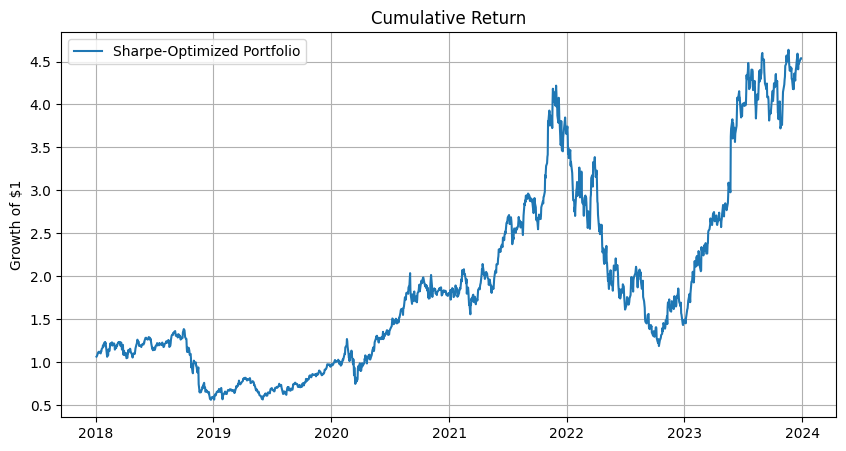

In [18]:
# Load log returns
returns = pd.read_csv("data/processed/log_returns.csv", index_col="Date", parse_dates=True)

# Load optimal weights
weights = pd.read_csv("data/weights/sharpe_optimal_weights.csv", index_col=0).squeeze()

# Multiply each column (asset) by its weight
weighted_returns = returns[weights.index] * weights

# Sum across columns to get portfolio return per day
portfolio_returns = weighted_returns.sum(axis=1)

# Compute cumulative return
cumulative_returns = (1 + portfolio_returns).cumprod()

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(cumulative_returns, label="Sharpe-Optimized Portfolio")
plt.title("Cumulative Return")
plt.ylabel("Growth of $1")
plt.grid()
plt.legend()
plt.show()

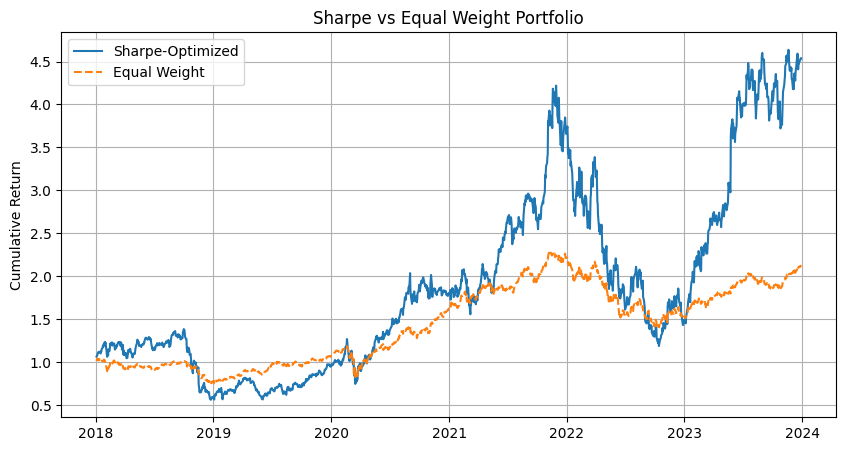

In [19]:
equal_weights = pd.Series(1/len(weights), index=weights.index)
equal_returns = (returns[equal_weights.index] * equal_weights).sum(axis=1)
equal_cum_returns = (1 + equal_returns).cumprod()

# Plot both
plt.figure(figsize=(10, 5))
plt.plot(cumulative_returns, label="Sharpe-Optimized")
plt.plot(equal_cum_returns, label="Equal Weight", linestyle="--")
plt.title("Sharpe vs Equal Weight Portfolio")
plt.ylabel("Cumulative Return")
plt.grid()
plt.legend()
plt.show()

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Load log returns
log_returns = pd.read_csv("data/processed/log_returns.csv", index_col="Date", parse_dates=True)

# Load optimized weights from CSV
optimal_weights = pd.read_csv("data/weights/sharpe_optimal_weights.csv", index_col=0).squeeze()  # Turn into Series

# Make sure the tickers in weights match the columns in log_returns
log_returns = log_returns[optimal_weights.index]

# Compute daily portfolio log return
portfolio_log_returns = log_returns.dot(optimal_weights)

# Save to file
portfolio_log_returns.to_csv("data/expected/portfolio_log_returns.csv")
print("✅ Portfolio log returns saved.")

✅ Portfolio log returns saved.


In [22]:
import numpy as np

# Cumulative return
cumulative_return = (portfolio_log_returns + 1).cumprod()

# Annualized volatility
volatility = portfolio_log_returns.std() * np.sqrt(252)

# Sharpe ratio (assuming risk-free rate = 0)
sharpe_ratio = portfolio_log_returns.mean() / portfolio_log_returns.std() * np.sqrt(252)

print("📈 Performance Metrics")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Volatility: {volatility:.2%}")
print(f"Cumulative Return: {cumulative_return.iloc[-1] - 1:.2%}")

📈 Performance Metrics
Sharpe Ratio: 0.75
Volatility: 51.35%
Cumulative Return: 353.74%
